# Projeto 3: GPU
### Filipe F. Borba  
### Insper
### Super Computação, Prof. Igor Montagner


## Introdução

O problema explorado nesse projeto é o algoritmo do Caixeiro Viajante. Este problema encontra-se na área de Otimização discreta, que estuda problemas de otimização baseados em uma sequência de escolhas e que a solução ótima só pode ser encontrada se enumerarmos todas as escolhas possíveis. Em outras palavras, só conseguimos achar a solução ótima se tivermos todas as soluções possíveis. Assim, não existem algoritmos mais eficientes de resolução, pois todos tem complexidade O(2^n) ou pior.

Ao realizar esse teste das sequências de escolhas em paralelo, podemos diminuir consideravelmente o consumo de tempo do programa, o que é bastante interessante para computacão paralela. Contudo, conseguimos potencializar ainda mais essa solução ao utilizar uma GPU que supera a CPU nesses casos, pois possui centenas de threads disponíveis para realizar os cálculos.

O problema do Caixeiro Viajante é o seguinte:

<img src="https://camo.githubusercontent.com/a4d91635c96d345fc31068a4420834d23654f82b/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f7468756d622f312f31312f474c504b5f736f6c7574696f6e5f6f665f615f74726176656c6c696e675f73616c65736d616e5f70726f626c656d2e7376672f35313270782d474c504b5f736f6c7574696f6e5f6f665f615f74726176656c6c696e675f73616c65736d616e5f70726f626c656d2e7376672e706e67" alt="TSP" style="width: 300px;"/>

```Um vendedor possui uma lista de empresas que ele deverá visitar em um certo dia. Não existe uma ordem fixa: desde que todos sejam visitados seu objetivo do dia está cumprido. Interessado em passar o maior tempo possível nos clientes ele precisa encontrar a sequência de visitas que resulta no menor caminho.```

Para nosso projeto em específico, temos algumas simplificações:
- o nosso caixeiro usa Waze e já sabe qual é o caminho com a menor distância entre dois pontos;
- ele começa seu trajeto na empresa 0. Ou seja, basta ele encontrar um trajeto que passe por todas as outras e volte a empresa ```0```;
- ele não pode passar duas vezes na mesma empresa. Ou seja, a saída é uma permutação de ```0 ... (N-1)```



Finalmente, os objetivos deste projeto são

1. implementar uma versão GPU em C++ do caixeiro viajante a partir de uma versão sequencial em C++.
2. Estudar e implementar os seguintes métodos paralelos:
    * busca local paralela usando 2-opt

** Como descrito em https://github.com/Insper/supercomp/blob/master/projeto-02/enunciado.md

## Organização do Projeto

O projeto foi realizado utilizando a linguagem C++ e o compilador nvcc do CUDA na máquina p2.xlarge da AWS (que possui uma GPU NVIDIA Tesla K80). Temos, então, alguns arquivos diferentes.

* Arquivo random_sol.cu, que gera 10.000 soluções aleatórias e retorna o melhor resultado entre elas.
* Arquivo 2opt_sol.cu, que gera 10.000 soluções aleatórias, mas as otimiza utilizando a busca local 2-opt.

Além disso, o projeto possui um CMakeLists.txt que possibilita a compilação dos executáveis. São eles:
* random_sol (solução aleatória em GPU)
* 2opt_spl (solução aleatória em GPU com otimização 2-opt)
* time_random_sol (com print de tempo - solução aleatória em GPU)
* time_2opt_spl (com print de tempo - solução aleatória em GPU com otimização 2-opt)

OBS: os outros executáveis foram criados para que a saída devolvesse o tempo, mas o código neles é igual.

Para compilar todos os executáveis, basta usar os seguintes comandos na pasta raíz do projeto:

```mkdir build; cd build; cmake ..; make ```

O comando ```make``` é responsável por compilar os executáveis.
Após isso, para iniciar cada executável, basta utilizar o comando 

```./nome_do_arquivo < ../tests/nome_da_entrada```

dentro da pasta ```build```.

# Resultados

## Comparação com CPU

O projeto em GPU tem diferenças bastante significativas em relação ao projeto em CPU. Podemos comparar com uma lista de prós em contras.

Projeto GPU:  
  
Vantagens:
- Consegue lidar com entradas muito maiores (CPU travava com 15, GPU roda em alguns ms entrada de tamanho 32).
- Problemas intratáveis em paralelo acabam sendo tratáveis, pois temos tempos mais razoáveis de execução.
- A solução encontrada não é muito pior que o caso ótimo.

Desvantagens:
- Maior dificuldade de paralelizar o código (código CUDA mais difícil que OpenMP).
- Malloc e Memcpy deixam o programa mais devagar para entradas muito pequenas.
- Não devolve o caminho ótimo nesse caso.

Podemos então concluir que a implementação em paralelo para problemas pequenos é bastante interessante, pois temos a solução ótima nesses casos. Contudo, para problemas maiores, a solução paralela demora muito mais, então a GPU acaba "brilhando" nesse caso. Apesar de não trazer a solução ótima, ela consegue computar o problema. 

Vejamos como isso se comporta na prática:

In [1]:
key = "/home/filipefborba/Documents/Keys/IgorNvidia.pem"
host = "ec2-user@ec2-54-81-98-139.compute-1.amazonaws.com" # MUDAR O IP AQUI
working_directory = "/home/ec2-user/borba/supercomp/projeto-03/" # MUDAR A PASTA AQUI

In [2]:
%matplotlib inline
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

In [3]:
# Realizar o build na máquina da aws.
print(subprocess.call(["ssh", "-i", key, host, "cd", working_directory, "&&", "mkdir", "build"]))
print(subprocess.call(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&", "cmake .."]))
print(subprocess.call(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&", "make", "-j4"]))

1
0
0


In [4]:
# Listar os executaveis
output = subprocess.check_output(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&", "ls"])
output = output.decode("utf-8").splitlines()
files = sorted([x for x in output if ((x.endswith("sol") or x.endswith("bb")) and not x.startswith("time"))])
files_time = sorted([x for x in output if ((x.endswith("sol") or x.endswith("bb")) and x.startswith("time"))])
print(files)
print(files_time)

['2opt-sol', 'random-sol', 'tsp-bb']
['time-2opt-sol', 'time-random-sol', 'time-tsp-bb']


In [5]:
# Pegar o nome das entradas. VEJA QUE ISSO É LOCAL E NAO NA AWS!
inputs = sorted([n for n in os.listdir("./tests/") if n.endswith('.txt') and not n.startswith("in")])
inputs

['berlin52.txt', 'ch130.txt', 'gil262.txt', 'pr439.txt']

In [6]:
# Teste básico para mostrar a diferença na saida
def run_basic_test(file, input_file):
    with open('./tests/' + input_file, 'rb', 0) as f:
        output = subprocess.check_output(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&",
                                     f"./{file}"], stdin=f, stderr=subprocess.STDOUT)
        output = output.decode("utf-8").splitlines()
    
    print(f"--{file}------{input_file}--")
    print("\n".join(output))

In [7]:
# O teste usado é o in10.txt
for f in files_time:
    run_basic_test(f, "in10.txt")

--time-2opt-sol------in10.txt--
9.73674
milisegundo(s).
6303.41552 0
0 9 5 2 1 7 8 3 4 6 
--time-random-sol------in10.txt--
8.6032
milisegundo(s).
6514.65691 0
0 5 2 1 8 7 3 4 6 9 
--time-tsp-bb------in10.txt--
1
milisegundo(s).
6303.41552 1
0 9 5 2 1 7 8 3 4 6 


Como pode-se observar com as saídas dos testes, o caminho encontrado pelo branch and bound é o ótimo e ele é retornado quase que imediatamente. Apesar do 2opt-sol demorar um pouquinho mais, ele também encontra o caminho ótimo, com o random-sol logo atrás, com um custo aceitável. Essa aproximação se dá pelo fato de testarmos muitas soluções (no caso, 10.000), o que permite uma aproximação melhor da solução ótima. Quanto maior o número de tentativas, mais provável do resultado ser o caminho ótimo. Nesse caso, pelo menos uma de nossas soluções otimizadas com o 2opt foi capaz de encontrar o melhor caminho possível, o que vai ser mais difícil de acontecer para caminhos maiores.

##  Testes de Desempenho

Aqui estamos preocupados com a diferença de desempenho, então o tamanho das entradas é maior. O tempo foi medido a partir da biblioteca <cuda_runtime.h> e o nvprof do próprio CUDA. Testaremos então o tempo de uma execução e a saída para as duas soluções em GPU (aleatório e 2-opt). Para isso, existem alguns testes do TSPLIB já resolvidos que serão utilizados como base aqui. São eles:
- berlin52.txt (N = 52) // Pequeno
- ch130.txt (N = 130)   // Médio
- gil262.txt (N = 262)  // Grande
- pr439.txt (N = 439)   // Muito Grande

Esses testes foram escolhidos pois já representam uma grande diferença de desempenho entre os executáveis. O pr439 serve mais para verificar os limites da máquina em termos de memória e processamentos.

In [8]:
# Converter us para ms
def fix_time(time):
    if (time.endswith("us")):
        return float(time[:-2])/1000
    elif (time.endswith("ms")):
        return float(time[:-2])
    elif (time.endswith("s")):
        return float(time[:-1])*1000
    else:
        print("time not us, ms or s")
        return 0

In [17]:
# Pegar nome e tempo de execucao
def get_name_and_time(output, name):
    if (name == "2opt-sol"):
        name = "opt_sol"
    if (name == "random-sol"):
        name = "random_sol"
    for s in output:
        found_name = s.find(name)
        if found_name != -1:
            result = s[found_name:found_name+len(name)]
            found_time = re.search('%(.*)s ', s)
            if (found_time == None):
                pass
            else:
                print(found_time.group(1).split()[0], result)
                return found_time.group(1).split()[0], result

In [18]:
# Tempos de alocacao e copia de memoria, alem de kernel.
def run_nvprof_test(file, input_file):
    with open('./tests/' + input_file, 'rb', 0) as f:
        output = subprocess.check_output(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&",
                                     "nvprof", f"./{file}"], stdin=f, stderr=subprocess.STDOUT)
        output = output.decode("utf-8").splitlines()
    
    print(f"--{file}------{input_file}--")
    kernel_time, kernel_name = get_name_and_time(output, str(file))
    htod_time, htod_name = get_name_and_time(output, "[CUDA memcpy HtoD]")
    dtoh_time, dtoh_name = get_name_and_time(output, "[CUDA memcpy DtoH]")
    malloc_time, malloc_name = get_name_and_time(output, "cudaMalloc")
    kernel_time = fix_time(kernel_time)
    htod_time = fix_time(htod_time)
    dtoh_time = fix_time(dtoh_time)
    malloc_time = fix_time(malloc_time)
    return [file, input_file,
        kernel_time, kernel_name,
        htod_time, htod_name,
        dtoh_time, dtoh_name,
        malloc_time, malloc_name
           ]

In [19]:
data = []
for i in inputs:
    for f in files[:-1]:
        data.append(run_nvprof_test(f, i))

--2opt-sol------berlin52.txt--
543.97ms opt_sol
3.9350us [CUDA memcpy HtoD]
113.15us [CUDA memcpy DtoH]
133.92ms cudaMalloc
--random-sol------berlin52.txt--
3.0383ms random_sol
3.9030us [CUDA memcpy HtoD]
115.78us [CUDA memcpy DtoH]
128.45ms cudaMalloc
--2opt-sol------ch130.txt--
8.72489s opt_sol
4.1920us [CUDA memcpy HtoD]
277.69us [CUDA memcpy DtoH]
125.39ms cudaMalloc
--random-sol------ch130.txt--
5.3729ms random_sol
4.1600us [CUDA memcpy HtoD]
278.52us [CUDA memcpy DtoH]
123.71ms cudaMalloc
--2opt-sol------gil262.txt--
75.0976s opt_sol
4.5440us [CUDA memcpy HtoD]
553.88us [CUDA memcpy DtoH]
124.41ms cudaMalloc
--random-sol------gil262.txt--
14.233ms random_sol
4.5120us [CUDA memcpy HtoD]
551.51us [CUDA memcpy DtoH]
132.29ms cudaMalloc
--2opt-sol------pr439.txt--
380.971s opt_sol
5.2480us [CUDA memcpy HtoD]
925.15us [CUDA memcpy DtoH]
123.67ms cudaMalloc
--random-sol------pr439.txt--
26.411ms random_sol
5.0240us [CUDA memcpy HtoD]
924.30us [CUDA memcpy DtoH]
133.09ms cudaMalloc


In [20]:
df = pd.DataFrame(data, dtype=np.float64, columns=["Executavel", "Entrada", "Tempo Kernel", "Nome Kernel",
                                                  "Tempo HtoD", "Nome HtoD", "Tempo DtoH", "Nome DtoH",
                                                  "Tempo Malloc", "Nome Malloc"])
df

# Todos os tempos estão em milissegundos!
# Coluna 0: Executável
# Coluna 1: Entrada
# Coluna 2: Tempo de execução Kernel
# Coluna 3: Nome kernel
# Coluna 4: Tempo de execução Memcpy
# Coluna 5: Nome memcpy HtoD
# Coluna 6: Tempo de execução Memcpy
# Coluna 7: Nome memcpy DtoH
# Coluna 8: Tempo de execução Malloc

,Executavel,Entrada,Tempo Kernel,Nome Kernel,Tempo HtoD,Nome HtoD,Tempo DtoH,Nome DtoH,Tempo Malloc,Nome Malloc
0,2opt-sol,berlin52.txt,543.9700,opt_sol,0.003935,[CUDA memcpy HtoD],0.11315,[CUDA memcpy DtoH],133.92,cudaMalloc
1,random-sol,berlin52.txt,3.0383,random_sol,0.003903,[CUDA memcpy HtoD],0.11578,[CUDA memcpy DtoH],128.45,cudaMalloc
2,2opt-sol,ch130.txt,8724.8900,opt_sol,0.004192,[CUDA memcpy HtoD],0.27769,[CUDA memcpy DtoH],125.39,cudaMalloc
3,random-sol,ch130.txt,5.3729,random_sol,0.004160,[CUDA memcpy HtoD],0.27852,[CUDA memcpy DtoH],123.71,cudaMalloc
4,2opt-sol,gil262.txt,75097.6000,opt_sol,0.004544,[CUDA memcpy HtoD],0.55388,[CUDA memcpy DtoH],124.41,cudaMalloc
5,random-sol,gil262.txt,14.2330,random_sol,0.004512,[CUDA memcpy HtoD],0.55151,[CUDA memcpy DtoH],132.29,cudaMalloc
6,2opt-sol,pr439.txt,380971.0000,opt_sol,0.005248,[CUDA memcpy HtoD],0.92515,[CUDA memcpy DtoH],123.67,cudaMalloc
7,random-sol,pr439.txt,26.4110,random_sol,0.005024,[CUDA memcpy HtoD],0.92430,[CUDA memcpy DtoH],133.09,cudaMalloc


Verificando o dataframe, podemos verificar que o tempo de alocação de memória e cópia acaba sendo quase insignificante perto do tempo de processamento do kernel das funções. Esse efeito acaba crescendo muito quanto maior as entradas: o tempo de "preparação" é mínimo e de processamento é máximo. Além disso, ele não acaba mudando muito de acordo com o tamanho da entrada.

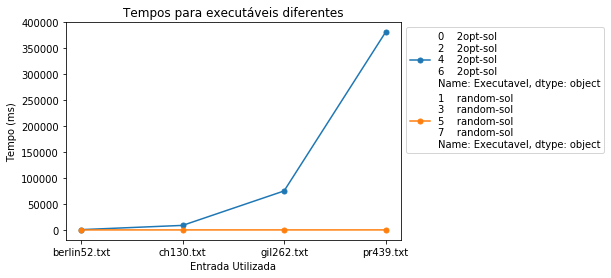

In [24]:
groups = df.groupby("Executavel")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["Entrada"], group["Tempo Kernel"], marker='o', linestyle='-', ms=5, label=group["Executavel"])
plt.title('Tempos para executáveis diferentes')
plt.ylabel('Tempo (ms)')
plt.xlabel('Entrada Utilizada')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

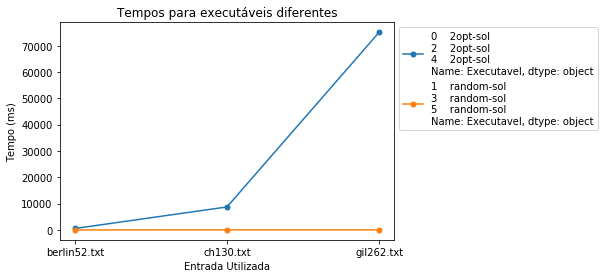

In [25]:
# Removi o último arquivo para ficar mais evidente a diferença para entradas mais razoaveis.
groups = df[:-2].groupby("Executavel")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["Entrada"], group["Tempo Kernel"], marker='o', linestyle='-', ms=5, label=group["Executavel"])
plt.title('Tempos para executáveis diferentes')
plt.ylabel('Tempo (ms)')
plt.xlabel('Entrada Utilizada')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Como podemos verificar nos gráficos acima, o algoritmo 2opt-sol acaba sendo MUITO mais lento que o random_sol. Isso acontece porque o 2opt realiza 2 fors que permutam a solução aleatória com o objetivo de encontrar um custo melhor. Além disso, para cada permutação, ele recalcula o custo total, sendo, novamente, bem ineficiente em termos de operações. Contudo, como pudemos verificar nos testes básicos, o 2opt acaba encontrando caminhos com custo bem menores, o que acaba sendo muito interessante, visto que sua implementação está totalmente ingênua. Portanto, o 2opt-sol sempre vai encontrar uma solução melhor que o random-sol.

Para melhorar o programa, seria necessário otimizar a memória e balancear melhor as cargas das threads. Ainda, seria interessante a utilização do Branch and Bound nesse caso, mas a implementação não é tão trivial. 